## Overview

In this project, guided by recent-(ish) results in graph theory, I investigate the possibility of reducing the number of training parameters in hidden neural network layers by a factor of 2 with little to no reduction in network performance, by constructing such layers from random 2-lifts of a layer with 1/2 the number of input and output vertices and 1/4 the number of training parameters.

In graph theory, a bipartite graph is a graph whose vertices can be separated into two distict sets, such that all edges in the graph have exactly one endpoint in either set. Hence, we can consider a single layer of a neural network as a bipartite graph, where the input and output nodes are the two distinct sets of vertices. A bipartite graph where every vertex pair in the distinct sets is connected by an edge (like a dense neural network layer) is called a complete bipartite graph (1).

The spectral gap of a graph is defined as the difference between its two largest eigenvalues. Graphs with a larger spectral gap are better connected, and hence have better mixing properties. Ramanujan graphs are d-regular graphs with  spectral gap at least 2√(d-1): This bound is determined as the largest possible gap for a d-regular graph as the number of vertices goes to infinity. An alternative definition of this condition for (c,d)-regular bipartite graphs requires that the spectral gap must be at least √(c-1)+√(d-1). Marcus, Spielman, and Srivastava (2015) gave a probabilistic proof that infinite families of bipartite Ramanujan graphs can be constructed by taking repeated 2-lifts of one such graph. Because finite complete bipartite graphs are Ramanujan, any such graph can be the seed of an infininte family of Ramanujan graphs by appropriate choice of 2-lifts (2).

Intuitively, neural networks should perform better if each layer has good expansion properties (i.e. good mixing properties), because such structure corresponds to better distributed flow of information through the network structure. Additionally, there is evidence that the brain has good expansion properties when viewed as a graph. Due to (1) and (2), we can therefore hypothesize that it is possible to construct non-dense neural network layers with optimal mixing by performing optimal 2-lifts of a smaller dense neural network layer.

Here we run into a roadblock because the proof in Marcus-Spielman-Srivastava is not constructive. However, J. Friedman (2003) shows that random lifts are nearly Ramanujan with high probability. Hence in this project I construct a custom neural network layer in Tensorflow as a random 2-lift of a smaller dense layer, include it in a neural network for an image classification task, and keep track of how its spectral gap corresponds to the loss and accuracy of the resulting network.

### Sources

Y. Bilu and N. Linial: Lifts, discrepancy and nearly optimal spectral gap. Combinatorica 26 (2006), 495-519. 
    http://dx.doi.org/10.1007/s00493-006-0029-7.
    
J. Friedman: Relative expanders or weakly relatively Ramanujan graphs. Duke Math.J . 118(1) (2003), 19–35.

A. Marcus, D. Spielman, and N. Srivastava: Interlacing families I: Bipartite Ramanujan graphs of all degrees.
    Annals of Mathematics 182 (2015), 307-325.

### Acknowledgements

I would like to thank Darren Upton (Jefferson Laboratories, Old Dominion University Physics) for helpful discussions & troubleshooting. This project was motivated by texts I read under the guidance of my MS thesis advisor, Prof. Thomas Koberda (University of Virginia Mathematics). 

## Code starts here

Import necessary libraries:

In [82]:
import math
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.activations import linear, relu, sigmoid, softmax
import tensorflow.experimental.numpy as tfnp
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
#%matplotlib widget
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import time

## Alzheimer's MRI dataset preprocessing

load Alzheimer's MRI image dataset into tf Dataset 'dataset'

In [83]:
dataset = tf.keras.utils.image_dataset_from_directory('/Users/olivia/Downloads/Dataset',color_mode='grayscale', batch_size = 32, image_size=(128, 128),
                                            shuffle=True)

#train, test = tf.keras.utils.image_dataset_from_directory('/Users/olivia/Downloads/Dataset',color_mode='grayscale', batch_size = 32, image_size=(128, 128),
                                            #shuffle=True,seed=42,validation_split=0.2,subset='both')
label_names = dataset.class_names
#train_labels = train.class_names
print(f'label_names ={label_names}')#, train_labels={train_labels}, dataset={dataset}')

#print(f'{normed_images[:1,100]}, {labels}')
#print(f'len(train_set)={len(train_set)}, len(val_set)={len(val_set)}')


Found 6400 files belonging to 4 classes.
label_names =['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


normalize pixel values in image files

In [84]:
def norm_data(image, label):
    # (max pixel value =255)
    normed_image = image/255.0

    return normed_image, label

# .map(fn) applies fn to each elt in dataset
normed_data = dataset.map(norm_data)

print(f'dataset={dataset}')
print(f'normed_data={normed_data}')


dataset=<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
normed_data=<MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


define function to split data into training, test, and cross validation sets

In [85]:
def split_data_sets(data, train_frac=0.8, test_frac=0.1):
    
    num_samples = len(list(normed_data))
    num_train = int(train_frac*num_samples)
    num_test = int(test_frac*num_samples)
    num_val = num_samples - num_train - num_test

    train = data.take(num_train)
    test = data.skip(num_train).take(num_test)
    val = data.skip(num_train+num_test).take(num_val)
    
    return train, test, val

split the data into train, test, cross val using above fn

In [86]:
#print(f'test')
train, test, val = split_data_sets(normed_data)

print(f'length train, test, val = {len(list(train))}, {len(list(test))}, {len(list(val))}')

length train, test, val = 160, 20, 20


compute class weights

In [87]:
y_train = tf.concat(list(map(lambda x: x[1], train)), axis=0)
class_weight = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train.numpy())
class_weights = dict(zip(np.unique(y_train), class_weight))
print(f'class_weights: {class_weights},\n y_train = {y_train.shape}')

class_weights: {0: 1.7802503477051461, 1: 23.703703703703702, 2: 0.49902534113060426, 3: 0.7182940516273849},
 y_train = (5120,)


In [66]:
#print(f'{train}')

<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


## Build & run the DNN model

This DNN model is identical to the 2-lift model we construct later except that all the layers are dense; it is meant as a control to which the network with 2-lift layers can be compared.

In [88]:
DNNmodel = Sequential([
    #Conv2D(2,3),
    #MaxPooling2D(),
    Conv2D(2,3),
    MaxPooling2D(),
    tf.keras.layers.Flatten(),      # in case pixel matrix is 2d
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # 4 possible labels
])

# include more hidden layers

DNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
#reduce learning rate
#early stopping?

#DNNmodel.summary()

fit dataset using DNN model

In [89]:
# MRI dataset fitting:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.001)
start_time = time.time()
DNNhistory = DNNmodel.fit(train, batch_size = 32, epochs = 30, validation_data = val,
                          class_weight = class_weights, callbacks = [early_stopping])
print(f'runtime = {time.time()-start_time}')

Epoch 1/30
160/160 [==============================] - 19s 111ms/step - loss: 1.3827 - accuracy: 0.3494 - val_loss: 1.1019 - val_accuracy: 0.6031
Epoch 2/30
160/160 [==============================] - 18s 110ms/step - loss: 1.1483 - accuracy: 0.4818 - val_loss: 1.2475 - val_accuracy: 0.4109
Epoch 3/30
160/160 [==============================] - 17s 109ms/step - loss: 0.9715 - accuracy: 0.5367 - val_loss: 1.4023 - val_accuracy: 0.3234
Epoch 4/30
160/160 [==============================] - 18s 109ms/step - loss: 0.7666 - accuracy: 0.5721 - val_loss: 0.7569 - val_accuracy: 0.6797
Epoch 5/30
160/160 [==============================] - 18s 109ms/step - loss: 0.6040 - accuracy: 0.6447 - val_loss: 0.7118 - val_accuracy: 0.6844
Epoch 6/30
160/160 [==============================] - 18s 109ms/step - loss: 0.5280 - accuracy: 0.6797 - val_loss: 0.6653 - val_accuracy: 0.7437
Epoch 7/30
160/160 [==============================] - 17s 109ms/step - loss: 0.4244 - accuracy: 0.7514 - val_loss: 0.5853 - val_ac

### Plot the DNN loss & accuracy over training

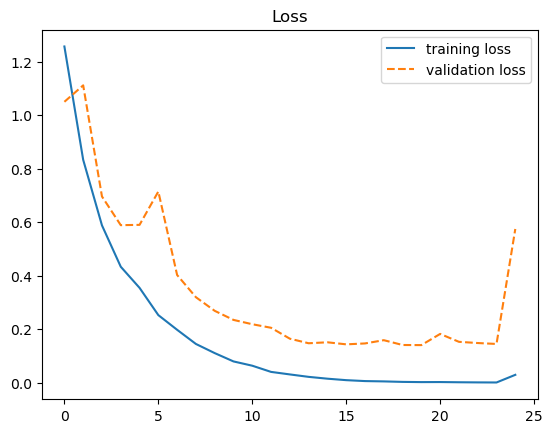

In [60]:
plt.plot(DNNhistory.epoch, DNNhistory.history['loss'], label='training loss')
plt.plot(DNNhistory.epoch, DNNhistory.history['val_loss'], label='validation loss', linestyle='dashed')
plt.title('Loss')
plt.legend()
plt.show()

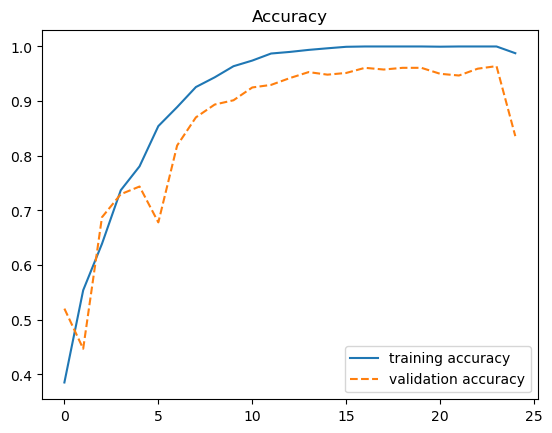

In [61]:
plt.plot(DNNhistory.epoch, DNNhistory.history['accuracy'], label='training accuracy')
plt.plot(DNNhistory.epoch, DNNhistory.history['val_accuracy'], label='validation accuracy', linestyle='dashed')
plt.title('Accuracy')
plt.legend()
plt.show()

## Toy versions of functions in Lift2 layer

Function to return a random 2-lift of a dense NN layer, such that the lift has n_input=m, n_output=m

In [68]:
# returns a random 2-lift of a complete (m/2)x(n/2) matrix; approximates w/ random row/col if m or n is odd
def two_lift(m:int,n:int):
        cross = tf.constant([[[1,0],[0,1]],[[0,1],[1,0]]]) # edge lift choices for image of given original conn. vertex pair
        rand_mn = tf.random.uniform(shape=[math.floor(m/2)*math.floor(n/2)], minval=0, maxval=2, dtype=tf.int64)   # even(m*n)-length tensor of random (0,1)'s'
        
        lift = tf.gather(cross, rand_mn)         #initialize lift
        #print(f'lift = {lift}')
                
        lift = tfnp.hstack(tfnp.vsplit(tfnp.vstack(lift), math.floor(n/2)))
        #print(f'lift = {lift}, lift.shape = {lift.shape}, lift.shape[-1] = {lift.shape[-1]}')
        
        #lift = np.hstack(np.vsplit(np.vstack(cross[rand_mn]), math.floor(n/2)))
        #print(f'og lift = {lift}')
        if m%2:
            #print(f'{tf.random.uniform(shape=(1,lift.shape[-1]), minval=1, maxval=2)}')
            lift = tfnp.vstack([lift, tf.random.uniform(shape=(1,lift.shape[-1]), minval=0, maxval=2, dtype=tf.int64) ]) # add on randomized last row/column
            #print(f'vert added lift = {lift}, lift.shape = {lift.shape[0]}')
        if n%2:
            lift = tfnp.hstack([lift, tf.random.uniform(shape=(lift.shape[-2], 1), minval=0, maxval=2, dtype=tf.int64) ]) # if m or n is odd
            #print(f'final lift = {lift}')
                         
        return lift


                             
#two_lift(10,15)

<tf.Tensor: shape=(10, 15), dtype=int64, numpy=
array([[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1],
       [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1],
       [0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1],
       [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]])>

Function to double all the rows of a given array: This is necessary for lining up weights with the lift matrix in the LNN construction.

Class with necessary functions for Lift2 custom tf layer

## Build and run neural network with Lift2 layer

Define custom 2-lift layer:

In [73]:
class Lift2(tf.keras.layers.Layer): #, Lift_funcs):
    def __init__(self, out_units, activation=None, use_bias=True, **kwargs):
        super(Lift2, self).__init__(**kwargs)
        self.out_units = out_units
        self.activation = tf.keras.activations.deserialize(activation)
        self.use_bias = use_bias
        
        
    # returns a random 2-lift of a complete (m/2)x(n/2) matrix; approximates w/ random row/col if m or n is odd
    def two_Lift(self,m:int,n:int):
        cross = tf.constant([[[1,0],[0,1]],[[0,1],[1,0]]]) # edge lift choices for image of given original conn. vertex pair
        rand_mn = tf.random.uniform(shape=[math.floor(m/2)*math.floor(n/2)], minval=0, maxval=2, dtype=tf.int64)   # even(m*n)-length tensor of random (0,1)'s'
        
        self.lift = tf.gather(cross, rand_mn)         #initialize lift
        #print(f'lift = {lift}')
                
        self.lift = tfnp.hstack(tfnp.vsplit(tfnp.vstack(self.lift), math.floor(n/2)))
        #print(f'lift = {lift}, lift.shape = {lift.shape}, lift.shape[-1] = {lift.shape[-1]}')
        
        #lift = np.hstack(np.vsplit(np.vstack(cross[rand_mn]), math.floor(n/2)))
        #print(f'og lift = {lift}')
        if m%2:
            #print(f'{tf.random.uniform(shape=(1,lift.shape[-1]), minval=1, maxval=2)}')
            self.lift = tfnp.vstack([self.lift, tf.random.uniform(shape=(1,self.lift.shape[-1]), minval=0, maxval=2, dtype=tf.int64) ]) # add on randomized last row/column
            #print(f'vert added lift = {lift}, lift.shape = {lift.shape[0]}')
        if n%2:
            self.lift = tfnp.hstack([self.lift, tf.random.uniform(shape=(self.lift.shape[-2], 1), minval=0, maxval=2, dtype=tf.int64) ]) # if m or n is odd
            #print(f'final lift = {lift}')
                       
        return self.lift

    
    # Calculates the spectral gap of the adj matrix & writes to a data file
    def spec_Gap(self, lift):
        # Adjacency matrix of Lift2 layer considered as a bipartite graph
        self.adj = tfnp.vstack([
            tfnp.hstack([ tf.zeros(shape=(lift.shape[-2],lift.shape[-2])), lift ]),
            tfnp.hstack([ tf.transpose(lift), tf.zeros(shape=(lift.shape[-1], lift.shape[-1])) ])
                    ])
        #print(f'self.adj = {self.adj}, shape={self.adj.shape}')
        self.evals = tf.linalg.eigvals(self.adj)
        #print(f'self.evals = {self.evals}, shape={self.evals.shape}')
        
        # Two largest distinct abs val eigenvalues of adj matrix.
        # (Bipartite graphs have symmetric eigenvalues, hence k=3.)
        self.spec2 = tf.math.top_k(tf.math.abs(self.evals), k=3)
        #print(f'self.spec2 = {self.spec2}')
        #print(f'{self.evals[self.spec2.indices[0]]}, {self.evals[self.spec2.indices[-1]]}')
        
        # Spectral gap of adjacency matrix
        self.spgap = self.spec2.values[0] - self.spec2.values[-1]
        #print(f'self.spgap = {self.spgap}')
        
        f = open('spec_gaps.dat', 'a')
        f.write(f'\n{self.spgap}')
        f.close()
    
    def double_Rows(self, w, tail=False):
        double_w = tfnp.reshape(tfnp.tile(w,2),w.shape*tf.constant([2,1]))
        if tail: double_w = double_w[:-1]
        
        return double_w
        
    def build(self, input_shape):
        #print(f'input_shape[-1] = {input_shape[-1]}, type = {type(input_shape[-1])}')
        #print(f'self.out_units = {self.out_units}, type = {type(self.out_units)}')
        self.lift = self.two_Lift(input_shape[-1], self.out_units)
        self.spec_Gap(self.lift)
        
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(initial_value=w_init(shape=(math.ceil(input_shape[-1]/2), self.out_units),
                             dtype='float32'), trainable=True)
        self.tail = input_shape[-1]%2
        
        b_init = tf.zeros_initializer()
        if self.use_bias: 
            self.b = tf.Variable(initial_value=b_init(shape=(self.out_units), dtype='float32'), trainable=True)
        
    def call(self, inputs):
        W_lifted = (self.lift*self.double_Rows(w=self.w, tail=self.tail)).astype(tf.float32)
        return self.activation(tf.linalg.matmul(inputs, W_lifted) + self.b)


In [75]:
LNNmodel = Sequential([
    Conv2D(2,3),
    MaxPooling2D(),
    tf.keras.layers.Flatten(),      # flatten 2D pixel matrix
    Dense(128, activation='relu'),
    Lift2(32, activation='relu'),
    Dense(4, activation='softmax')  # 4 possible labels
])

LNNmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [76]:
#tf.compat.v1.enable_eager_execution(
#    config=None, device_policy=None, execution_mode=None)

#LNNhistory = LNNmodel.fit(X_train, y_train, batch_size = 32, epochs = 10, validation_data = (X_val, y_val))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.001)
start_time = time.time()
LNNhistory = LNNmodel.fit(train, epochs = 30, batch_size=32, validation_data = val, class_weight = class_weights, callbacks = [early_stopping])
print(f'runtime = {time.time()-start_time}')

Epoch 1/30
160/160 [==============================] - 22s 121ms/step - loss: 1.3622 - accuracy: 0.3053 - val_loss: 1.0791 - val_accuracy: 0.5344
Epoch 2/30
160/160 [==============================] - 20s 126ms/step - loss: 1.0737 - accuracy: 0.4824 - val_loss: 1.0059 - val_accuracy: 0.5375
Epoch 3/30
160/160 [==============================] - 18s 113ms/step - loss: 0.7699 - accuracy: 0.5531 - val_loss: 0.8269 - val_accuracy: 0.5844
Epoch 4/30
160/160 [==============================] - 19s 117ms/step - loss: 0.6314 - accuracy: 0.6092 - val_loss: 0.8478 - val_accuracy: 0.5906
Epoch 5/30
160/160 [==============================] - 19s 115ms/step - loss: 0.5041 - accuracy: 0.6982 - val_loss: 0.6570 - val_accuracy: 0.6875
Epoch 6/30
160/160 [==============================] - 18s 111ms/step - loss: 0.4065 - accuracy: 0.7564 - val_loss: 0.6081 - val_accuracy: 0.7297
Epoch 7/30
160/160 [==============================] - 18s 110ms/step - loss: 0.3501 - accuracy: 0.7889 - val_loss: 0.5567 - val_ac

### Plot LNN loss & accuracy over training

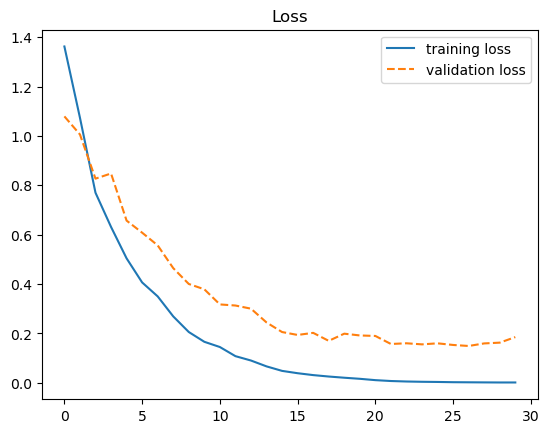

In [77]:
plt.plot(LNNhistory.epoch, LNNhistory.history['loss'], label='training loss')
plt.plot(LNNhistory.epoch, LNNhistory.history['val_loss'], label='validation loss', linestyle='dashed')
plt.title('Loss')
plt.legend()
plt.show()

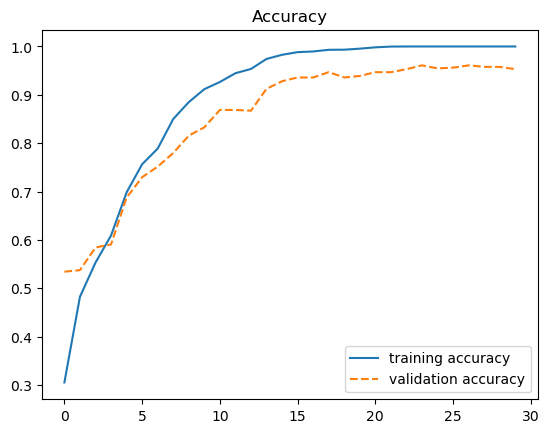

In [78]:
plt.plot(LNNhistory.epoch, LNNhistory.history['accuracy'], label='training accuracy')
plt.plot(LNNhistory.epoch, LNNhistory.history['val_accuracy'], label='validation accuracy', linestyle='dashed')
plt.title('Accuracy')
plt.legend()
plt.show()

In [79]:
test_loss_acc = LNNmodel.evaluate(test)
f = open('test_loss_acc.dat', 'a')
f.write(f'\n{test_loss_acc}')
f.close()

20/20 [==============================] - 2s 50ms/step - loss: 0.0773 - accuracy: 0.9797


### Status as of Aug. 1, 2023:

Pending Rivanna computing allocation, will train a sampling of different randomized trials of the 2-lift neural network (LNN), and plot lift layer spectral gap against loss and accuracy on the test set.